In [1]:
import CairoMakie
import CSV
import FASTX
import HDF5
import Infernal
import KernelDensity
import Makie
import RestrictedBoltzmannMachines as RBMs
import Rfam
import SamApp2024
import StatsBase
using BioSequences: LongRNA
using DataFrames: DataFrame
using Distributions: Gamma
using Distributions: logpdf
using Distributions: pdf
using Distributions: Poisson
using LinearAlgebra: Diagonal
using LinearAlgebra: eigen
using Makie: @L_str
using NaNStatistics: nansum
using NaNStatistics: nanmean
using NaNStatistics: nanstd
using ProgressMeter: @showprogress
using Random: bitrand
using RestrictedBoltzmannMachines: free_energy
using Statistics: cor
using Statistics: mean
using StatsBase: countmap

In [2]:
# load SHAPE data
shape_data_045 = SamApp.load_shapemapper_data_pierre_demux_20230920(; demux=true);

# split rep0 from rep4+5
shape_data_rep0 = SamApp.select_conditions_20231002(shape_data_045, filter(endswith("_rep0"), shape_data_045.conditions));
shape_data_rep45 = SamApp.select_conditions_20231002(shape_data_045, filter(endswith("_rep45"), shape_data_045.conditions));

In [3]:
conds_sam_rep0 = identity.(indexin(["SAMAP_1M7_0-1SAM_5Mg_T30C_rep0", "SAMAP_1M7_0-5SAM_5Mg_T30C_rep0", "SAMAP_1M7_1SAM_5Mg_T30C_rep0"], shape_data_rep0.conditions));
conds_mg_rep0 = identity.(indexin(["SAMAP_1M7_noSAM_5Mg_T30C_rep0"], shape_data_rep0.conditions));
conds_30C_rep0 = identity.(indexin(["SAMAP_1M7_noSAM_noMg_T30C_rep0"], shape_data_rep0.conditions));

conds_sam_rep45 = identity.(indexin(["SAMAP_1M7_0-1SAM_5Mg_T30C_rep45", "SAMAP_1M7_1SAM_5Mg_T30C_rep45"], shape_data_rep45.conditions));
conds_mg_rep45 = identity.(indexin(["SAMAP_1M7_noSAM_5Mg_T30C_rep45"], shape_data_rep45.conditions));
conds_30C_rep45 = identity.(indexin(["SAMAP_1M7_noSAM_noMg_T30C_rep45"], shape_data_rep45.conditions));

@show conds_sam_rep0 conds_mg_rep0 conds_30C_rep0;
@show conds_sam_rep45 conds_mg_rep45 conds_30C_rep45;

conds_sam_rep0 = [1, 2, 3]
conds_mg_rep0 = [4]
conds_30C_rep0 = [5]
conds_sam_rep45 = [1, 2]
conds_mg_rep45 = [4]
conds_30C_rep45 = [6]


In [4]:
(; bps, nps, pks) = SamApp.RF00162_sites_paired()

(bps = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14  …  97, 100, 101, 102, 103, 104, 105, 106, 107, 108], nps = [9, 10, 11, 12, 18, 19, 20, 24, 32, 33  …  73, 74, 75, 87, 88, 89, 90, 91, 98, 99], pks = [25, 26, 27, 28, 77, 78, 79, 80])

In [5]:
rbm_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_syn_rbm")
inf_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_syn_inf")
full_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_full30")
seed_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_seed70")
nat_seqs = full_seqs ∪ seed_seqs;

In [6]:
aptamer_rbm_energies = [
    ismissing(seq) ? missing : 
    free_energy(SamApp.rbm2022(), SamApp.onehot(LongRNA{4}(seq)))
    for seq in shape_data_045.aligned_sequences
];

In [7]:
_rbmlo = rbm_seqs ∩ findall((!ismissing).(aptamer_rbm_energies) .&& (aptamer_rbm_energies .< -300));
_rbmhi = rbm_seqs ∩ findall((!ismissing).(aptamer_rbm_energies) .&& (aptamer_rbm_energies .> -300));

In [8]:
ΔR_sam = (
    nanmean(shape_data_rep0.shape_reactivities[:, :, conds_sam_rep0]; dim=3) .- 
    shape_data_rep0.shape_reactivities[:, :, only(conds_mg_rep0)]
);

ΔR_sam_avg_seed = nanmean(ΔR_sam[:, seed_seqs]; dim=2)
ΔR_sam_std_seed = nanstd(ΔR_sam[:, seed_seqs]; dim=2);

ΔR_sam_avg_full = nanmean(ΔR_sam[:, full_seqs]; dim=2)
ΔR_sam_std_full = nanstd(ΔR_sam[:, full_seqs]; dim=2);

ΔR_sam_avg_rbmlo = nanmean(ΔR_sam[:, _rbmlo]; dim=2)
ΔR_sam_std_rbmlo = nanstd(ΔR_sam[:, _rbmlo]; dim=2);

ΔR_sam_avg_rbmhi = nanmean(ΔR_sam[:, _rbmhi]; dim=2)
ΔR_sam_std_rbmhi = nanstd(ΔR_sam[:, _rbmhi]; dim=2);

ΔR_sam_avg_inf = nanmean(ΔR_sam[:, inf_seqs]; dim=2)
ΔR_sam_std_inf = nanstd(ΔR_sam[:, inf_seqs]; dim=2);

In [9]:
bps_reactivities_rep0 = shape_data_rep0.shape_reactivities[bps, seed_seqs, conds_sam_rep0];
nps_reactivities_rep0 = shape_data_rep0.shape_reactivities[nps, seed_seqs, conds_sam_rep0];
all_reactivities_rep0 = shape_data_rep0.shape_reactivities[:, nat_seqs, conds_sam_rep0];

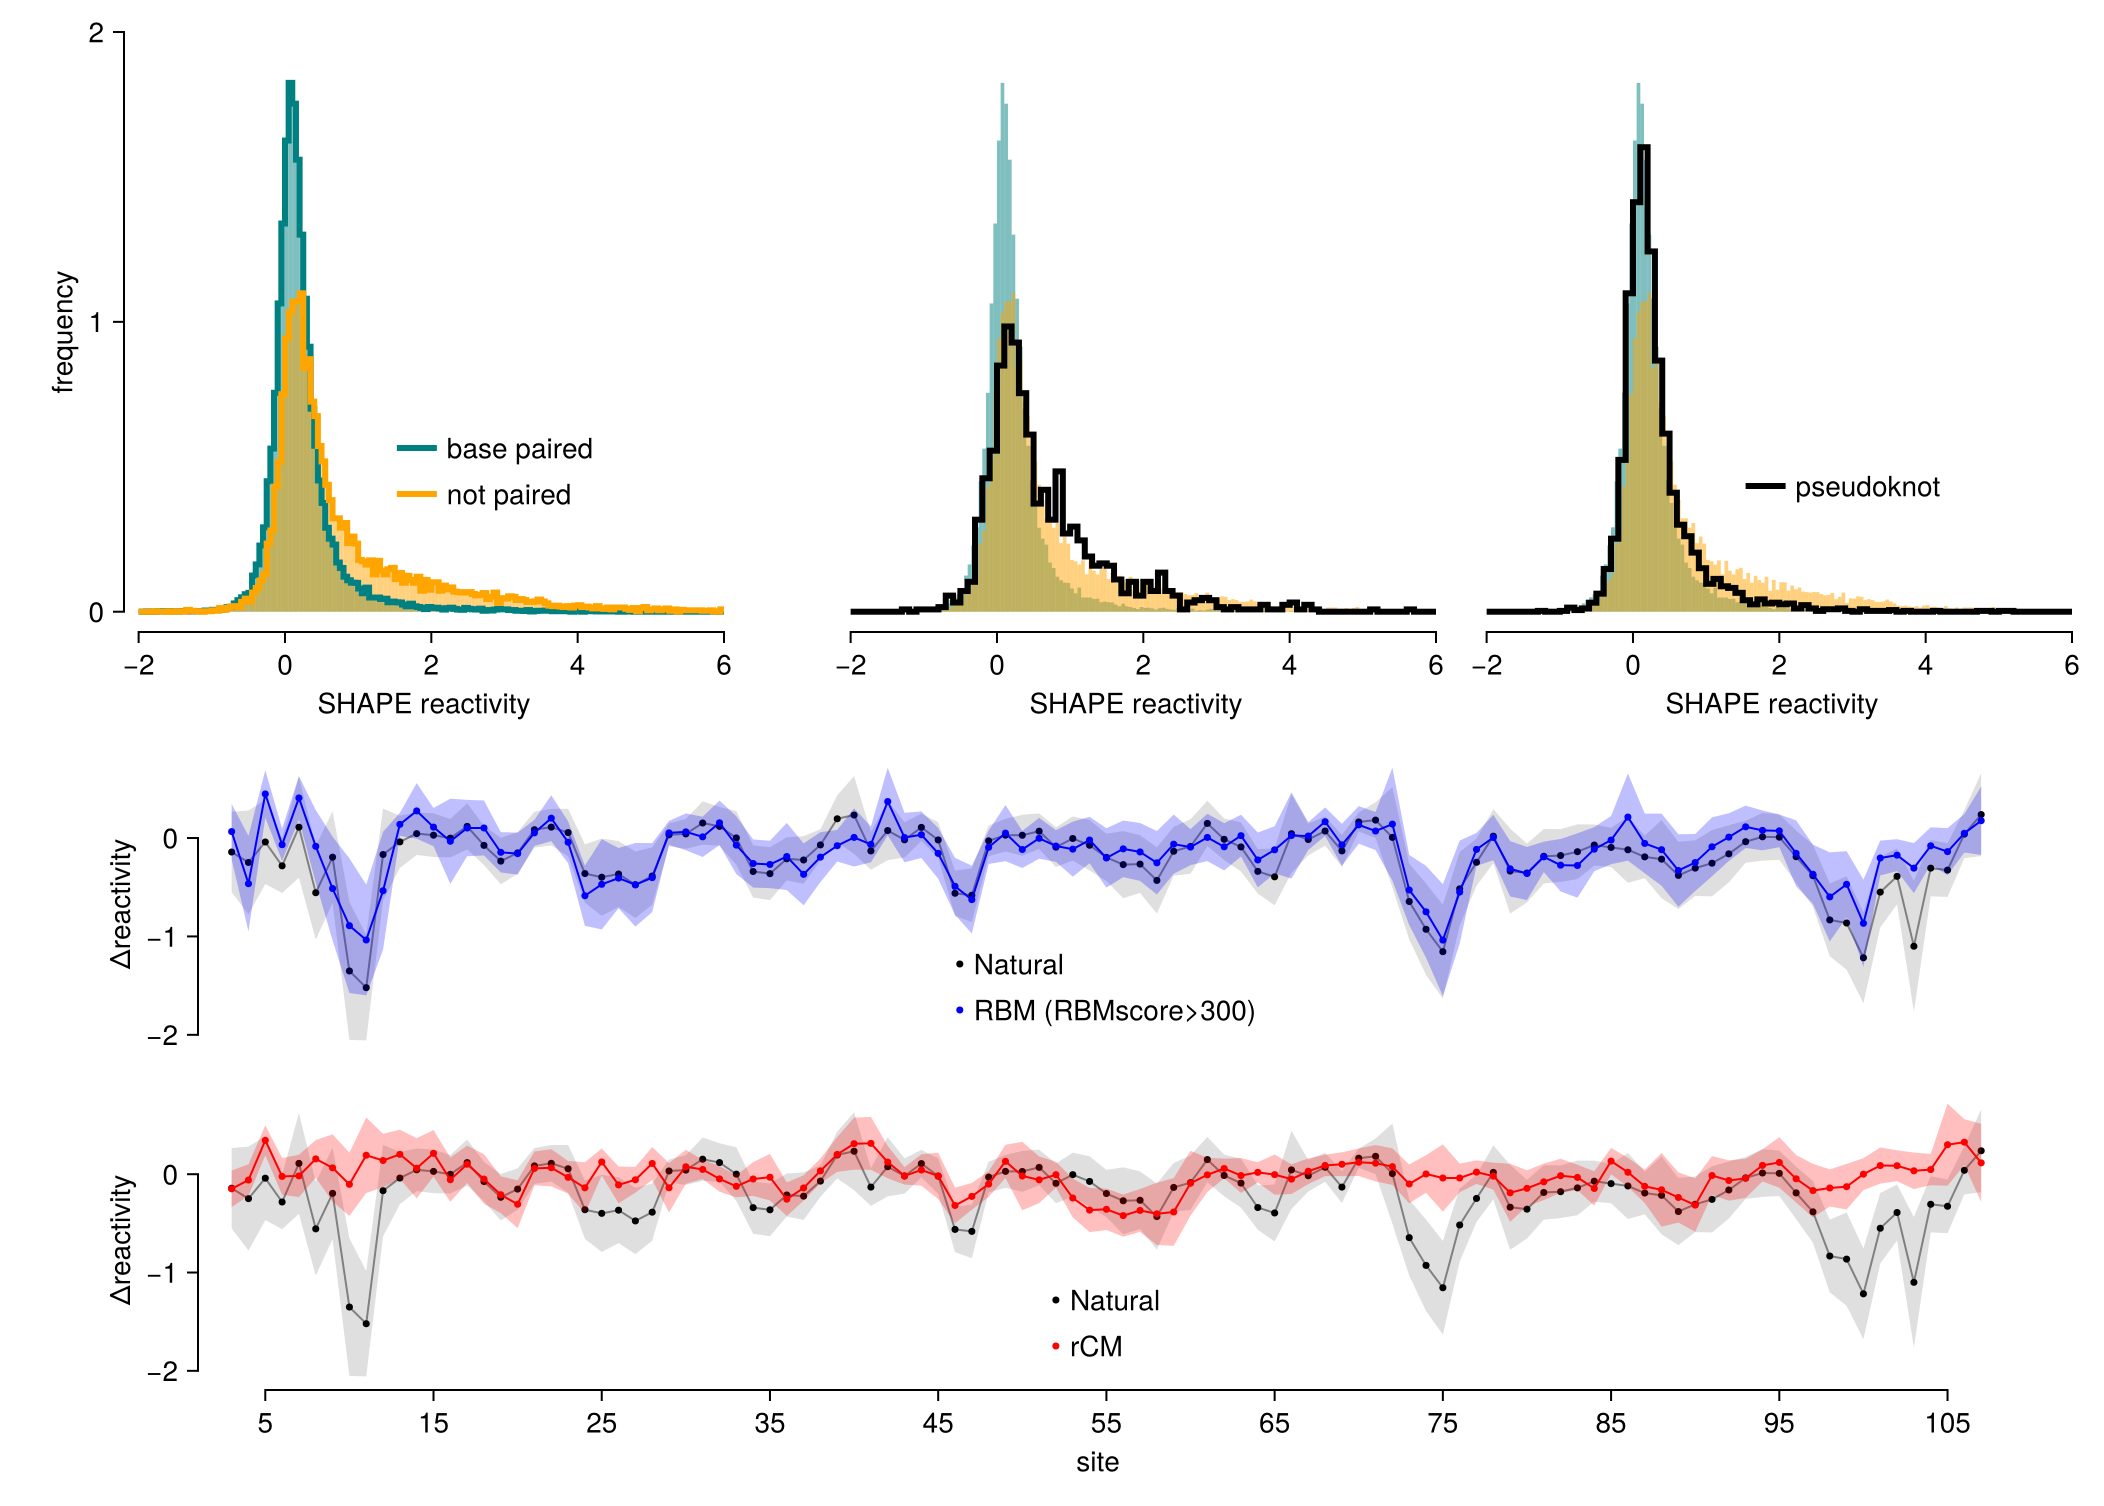

In [14]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300, xlabel="SHAPE reactivity", ylabel="frequency", xgridvisible=false, ygridvisible=false, xticks=-2:2:6, yticks=0:2, xtrimspine=true, ytrimspine=true)
Makie.hist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[bps, nat_seqs, conds_sam_rep0])), normalization=:pdf, bins=-2:0.05:6, color=(:teal, 0.5), gap=-0.01)
Makie.hist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[nps, nat_seqs, conds_sam_rep0])), normalization=:pdf, bins=-2:0.05:6, color=(:orange, 0.5), gap=-0.01)
Makie.stephist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[bps, nat_seqs, conds_sam_rep0])), label="base paired", normalization=:pdf, bins=-2:0.05:6, linewidth=3, color=:teal)
Makie.stephist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[nps, nat_seqs, conds_sam_rep0])), label="not paired", normalization=:pdf, bins=-2:0.05:6, linewidth=3, color=:orange)
Makie.xlims!(-2.2, 6)
Makie.ylims!(-0.07, 2)
#Makie.axislegend(ax, framevisible=false, patchlabelgap=3, position=(-0.02, 1))
Makie.axislegend(ax, position=(0.7, 0.2), framevisible=false)
Makie.hidespines!(ax, :t, :r)

_dummy_ax = Makie.Axis(fig[1,2], width=20, xgridvisible=false, ygridvisible=false)
Makie.hidespines!(_dummy_ax, :t, :b, :r, :l)
Makie.hidexdecorations!(_dummy_ax)
Makie.hideydecorations!(_dummy_ax)

ax = Makie.Axis(fig[1,3], width=300, height=300, xlabel="SHAPE reactivity", ylabel="frequency", xgridvisible=false, ygridvisible=false, xticks=-2:2:6, yticks=0:2, xtrimspine=true, ytrimspine=true)
Makie.hist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[bps, nat_seqs, conds_sam_rep0])), label="b.p.", normalization=:pdf, bins=-2:0.05:6, color=(:teal, 0.5), gap=-0.01)
Makie.hist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[nps, nat_seqs, conds_sam_rep0])), label="n.p.", normalization=:pdf, bins=-2:0.05:6, color=(:orange, 0.5), gap=-0.01)
Makie.stephist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[pks, nat_seqs, conds_mg_rep0])), label="p.k.", normalization=:pdf, bins=-2:0.1:6, linewidth=3, color=:black)
Makie.xlims!(-2.2, 6)
Makie.ylims!(-0.07, 2)
Makie.hidespines!(ax, :t, :r, :l)
Makie.hideydecorations!(ax)

ax = Makie.Axis(fig[1,4], width=300, height=300, xlabel="SHAPE reactivity", xgridvisible=false, ygridvisible=false, xticks=-2:2:6, yticks=0:2, xtrimspine=true, ytrimspine=true)
Makie.hist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[bps, nat_seqs, conds_sam_rep0])), normalization=:pdf, bins=-2:0.05:6, color=(:teal, 0.5), gap=-0.01)
Makie.hist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[nps, nat_seqs, conds_sam_rep0])), normalization=:pdf, bins=-2:0.05:6, color=(:orange, 0.5), gap=-0.01)
Makie.stephist!(ax, filter(x -> -2 < x < 6, vec(shape_data_rep0.shape_reactivities[pks, nat_seqs, conds_sam_rep0])), label="pseudoknot", normalization=:pdf, bins=-2:0.1:6, linewidth=3, color=:black)
Makie.xlims!(-2.2, 6)
Makie.ylims!(-0.07, 2)
Makie.axislegend(ax, position=(0.7, 0.2), framevisible=false)
Makie.hidespines!(ax, :t, :r, :l)
Makie.hideydecorations!(ax)

_xs = 3:107

ax = Makie.Axis(fig[2,:], width=900, height=150, xticks=5:10:108, yticks=-2:1:1, xgridvisible=false, ygridvisible=false, ylabel="Δreactivity", xtrimspine=true, ytrimspine=true)

Makie.band!(ax, _xs, (ΔR_sam_avg_seed - ΔR_sam_std_seed/2)[_xs], (ΔR_sam_avg_seed + ΔR_sam_std_seed/2)[_xs], markersize=5, color=(:gray, 0.25))
Makie.lines!(ax, _xs, ΔR_sam_avg_seed[_xs], linewidth=1, color=:gray)
Makie.scatter!(ax, _xs, ΔR_sam_avg_seed[_xs], markersize=5, color=:black, label="Natural")

Makie.band!(ax, _xs, (ΔR_sam_avg_rbmlo - ΔR_sam_std_rbmlo/2)[_xs], (ΔR_sam_avg_rbmlo + ΔR_sam_std_rbmlo/2)[_xs], markersize=5, color=(:blue, 0.25))
Makie.lines!(ax, _xs, ΔR_sam_avg_rbmlo[_xs], linewidth=1, color=:blue)
Makie.scatter!(ax, _xs, ΔR_sam_avg_rbmlo[_xs], markersize=5, color=:blue, label="RBM (RBMscore>300)")
Makie.axislegend(ax, position=(0.5, 0), framevisible=false, patchlabelgap=-3)
Makie.xlims!(1, 108)
Makie.hidespines!(ax, :t, :r, :b)
Makie.hidexdecorations!(ax)

ax = Makie.Axis(fig[3,:], width=900, height=150, xticks=5:10:108, yticks=-2:1:1, xgridvisible=false, ygridvisible=false, xlabel="site", ylabel="Δreactivity", xtrimspine=true, ytrimspine=true)

Makie.band!(ax, _xs, (ΔR_sam_avg_seed - ΔR_sam_std_seed/2)[_xs], (ΔR_sam_avg_seed + ΔR_sam_std_seed/2)[_xs], markersize=5, color=(:gray, 0.25))
Makie.lines!(ax, _xs, ΔR_sam_avg_seed[_xs], linewidth=1, color=:gray)
Makie.scatter!(ax, _xs, ΔR_sam_avg_seed[_xs], markersize=5, color=:black, label="Natural")

Makie.band!(ax, _xs, (ΔR_sam_avg_inf - ΔR_sam_std_inf/2)[_xs], (ΔR_sam_avg_inf + ΔR_sam_std_inf/2)[_xs], markersize=5, color=(:red, 0.25))
Makie.lines!(ax, _xs, ΔR_sam_avg_inf[_xs], linewidth=1, color=:red)
Makie.scatter!(ax, _xs, ΔR_sam_avg_inf[_xs], markersize=5, color=:red, label="rCM")
Makie.axislegend(ax, position=(0.5, 0), framevisible=false, patchlabelgap=-3)
Makie.hidespines!(ax, :t, :r)
Makie.xlims!(1, 108)

# Makie.Label(fig[1,1][1,1,Makie.TopLeft()], "A)", font=:bold, padding=(0,0,10,10))
# Makie.Label(fig[1,2][1,1,Makie.TopLeft()], "B)", font=:bold, padding=(0,0,10,10))
# Makie.Label(fig[1,3][1,1,Makie.TopLeft()], "C)", font=:bold, padding=(0,0,10,10))
# Makie.Label(fig[2,:][1,1,Makie.TopLeft()], "D)", font=:bold, padding=(0,0,0,0))
# Makie.Label(fig[3,:][1,1,Makie.TopLeft()], "E)", font=:bold, padding=(0,0,0,0))

Makie.resize_to_layout!(fig)
Makie.save("/workspaces/SamApp.jl/notebooks/2024-03-14 New paper figures/Figures/SHAPE reactivities.pdf", fig)
fig